In [9]:
import sys, os, io, json, numpy as np, random, time
#from sklearn.metrics import roc_auc_score
from importlib import reload
import forest
reload(forest)
from forest import build_tree, EMatrix
import xgboost as xgb
import tensorflow as tf
import split
reload(split)
from split import SplitMaker
#from split import make_split_quick, make_gax, split_quick_graph, split_quick_graph_transpose
import graphviz
from sklearn import metrics

In [10]:
split_maker_old = SplitMaker.make_split_old()

In [11]:
pool = np.load('../prepare_dataset/pool_00.npz')
features_bool, f_time, label_orig = (pool[name] for name in ['features', 'f_time', 'label'])
label = label_orig

In [12]:
np.random.seed(42)
features_orig = np.random.normal(loc=features_bool*1.0, scale=0.01)
#features = features[:150000,:]; label = label_orig[:150000, :]

f_test, l_test = features_orig[150000:,:], label_orig[150000:, :]
features = features_orig[:150000,:]; label = label_orig[:150000, :]

### Тестирование инвариантности сплита относительно замены местами столбцов фичей

```
features_swap = np.concatenate([features[:,7:8], features[:,1:7], features[:,0:1], features[:,8:]], axis=1)

%%time
split_maker_old.split(np.zeros(label.shape), features, label)
#make_split(np.zeros(label.shape), features, label)

%%time
split_maker_old.split(np.zeros(label.shape), features_swap, label)
#make_split(np.zeros(label.shape), features_swap, label)
```

In [13]:
features.shape, label.shape

((150000, 15), (150000, 1))

In [14]:
global_ax = split_maker_old.make_gax(features)
featuresT = features.T
global_axT = global_ax.T

In [15]:
split_maker = SplitMaker.make_split_new(reduce_axis=0, make_transpose=True)

In [17]:
%%time
start_params = {'max_depth': 8, 'learning_rate':0.3, 'transposed_feature1111': 1, 'unbalanced_penalty':0.001}
tf.constant
forest.time1 = forest.time2 =0
forest.time3 = []
with tf.Session(graph=split_maker.graph) as s:
    tree = build_tree(start_params, EMatrix(featuresT if split_maker.reduce_axis==1 else features, 
                                            label, np.zeros(label.shape), 
                                            gax=global_axT if split_maker.reduce_axis==1 else global_ax, 
                                            splitgax=True), split_maker=split_maker, sess=s)
print("\nsplit time = {:.5f}, {:.5f}, [{}]".format(forest.time1, forest.time2, ", ".join("{:.5f}".format(tt) for tt in forest.time3)), file=sys.stderr)
tree_arrays = forest.init_arrays(tree, forest.init_id(tree))

1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  1  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  2  3  4  5  5  4  5  5  3  4  5  5  4  5  5  

CPU times: user 5.95 s, sys: 702 ms, total: 6.65 s
Wall time: 2.46 s



split time = 6.48210, 0.11958, [0.56936, 0.25675, 0.11876, 0.07117, 0.04505, 0.03123, 0.02446, 0.02204, 0.01672, 0.01750, 0.01835, 0.01771, 0.03059, 0.02957, 0.02842, 0.01749, 0.01735, 0.01694, 0.01537, 0.05229, 0.04000, 0.02750, 0.02164, 0.01992, 0.02908, 0.02420, 0.01675, 0.02618, 0.02361, 0.01735, 0.01628, 0.01749, 0.01569, 0.01578, 0.07254, 0.06795, 0.03937, 0.02690, 0.01837, 0.02283, 0.02793, 0.02018, 0.02394, 0.04666, 0.03199, 0.02587, 0.02405, 0.02039, 0.02112, 0.01716, 0.02446, 0.02002, 0.02054, 0.02088, 0.01788, 0.01691, 0.01722, 0.01925, 0.01864, 0.01643, 0.01498, 0.01407, 0.01609, 0.01409, 0.01534, 0.14897, 0.10517, 0.09365, 0.05791, 0.03351, 0.02455, 0.02484, 0.03583, 0.02614, 0.02137, 0.05693, 0.04825, 0.02976, 0.03133, 0.02488, 0.02344, 0.01694, 0.02685, 0.02468, 0.02351, 0.01929, 0.01995, 0.01551, 0.01493, 0.01383, 0.01774, 0.01570, 0.01475, 0.01664, 0.01696, 0.01635, 0.01520, 0.04235, 0.04007, 0.03253, 0.03189, 0.03037, 0.01579, 0.01628, 0.01639, 0.01604, 0.02077, 0.01

In [7]:
import pstats
p = pstats.Stats('build_tree.prof')
#p.sort_stats('tottime').print_stats()

In [8]:
pred = forest.tree_apply(tree_arrays, features)
pred_test = forest.tree_apply(tree_arrays, f_test)
auc1l = metrics.roc_auc_score(label[:, 0], pred)
auc1t = metrics.roc_auc_score(label[:, 0], pred_test)
auc0 = metrics.roc_auc_score(label[:, 0], np.zeros(label.shape[0]))
auc1l, auc1t, auc0

(0.564954307935, 0.5019091667880746, 0.5)

In [9]:
#tree.left.left.left.left.val, tree.val
tree.left.left

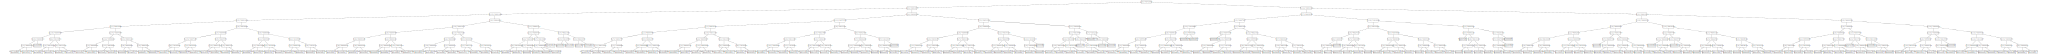

In [10]:
forest.tree2gv(tree)

In [13]:
id(split_quick_graph), id(split_quick_graph_transpose)

(140477725063656, 140477725063040)

In [12]:
%%time
boost_params = {'max_depth': 4, 'learning_rate':0.3, 'splitgax': True, 'transposed_feature': 0, 'unbalanced_penalty':0.001}
booster = forest.train(boost_params, EMatrix(featuresT if boost_params['transposed_feature'] else features, label), num_boost_round=50)

transposed_feature 0
graph_1: 140477725064888
graph_2: 140477725064608
graph_selected: 140477725064608
make_split_quick graph id: 140477725063656



0 round


TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("features_quick_reduce_axis_0_make_transpose_True_use_my_comsum_True_:0", shape=(?, ?), dtype=float32) is not an element of this graph.

In [ ]:
####################################################

In [ ]:
#%%time
#gax13 = make_gax(features)
#print(gax13.shape)

In [ ]:
pred2 = booster.predict(features)
pred2b = booster.predict(features, tree_limit=10)
pred_test = booster.predict(f_test)
main_auc_l = metrics.roc_auc_score(label[:, 0], pred2)
main_auc_t = metrics.roc_auc_score(l_test[:, 0], pred_test)
main_auc_l, main_auc_t

In [ ]:
0.5783850422568331,0.547297544877569

In [ ]:
#np.min(pred2b), np.max(pred2b)

In [ ]:
tree2gv(booster.forest[45][0])

In [ ]:
dmat = xgb.DMatrix(features, label)

In [ ]:
%%time
params = {'max_depth': 4, 'objective': 'binary:logistic', 'eta': 0.3, 'tree_method': 'exact', 'lambda': 1}
model = xgb.train(params, dmat, num_boost_round=50)

In [ ]:
dmat_test = xgb.DMatrix(f_test, l_test)

In [ ]:
pred_fast = model.predict(dmat)
pred_test = model.predict(dmat_test)

metrics.roc_auc_score(label[:, 0], pred_fast), metrics.roc_auc_score(l_test[:, 0], pred_test)

In [ ]:
pred_fast = model.predict(dmat, ntree_limit=35)
metrics.roc_auc_score(label[:, 0], pred_fast)

In [ ]:
pred2b = booster.predict(features, tree_limit=15)
metrics.roc_auc_score(label[:, 0], pred2b)

In [ ]:
0.5987831226886691, 0.5457320402572653

In [ ]:
qq = -np.log(1/pred_fast-1) 
np.min(qq), np.max(qq)

In [ ]:
diff = np.abs(qq - pred2b)
np.mean(diff > 0.1)

In [ ]:
model.dump_model('xgb.dump')

In [ ]:
tree2gv(booster.forest[1][0])

In [ ]:
!cat xgb.dump | tail -n+$(echo 39*31+31 | bc) | head -n 100